In [191]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define environment

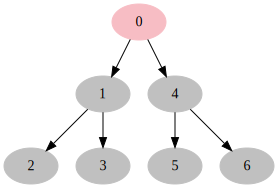

In [192]:
from distributions import Normal
from mouselab import MouselabEnv

def make_env(mu=0, sigma=6, quantization=6, branching=(2,2), **kwargs):
    reward = Normal(mu, sigma).to_discrete(quantization).apply(int)
    return MouselabEnv.new_symmetric(branching, reward, cost=1, **kwargs)

env = make_env(ground_truth=False, term_belief=True)
env.render()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [193]:
from exact import solve
from policies import SoftmaxPolicy
Q, V, *_ = solve(env)
optimal_policy = SoftmaxPolicy(Q)
V(env.init)

3.3012811413394685

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [194]:

from agents import run_episode

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

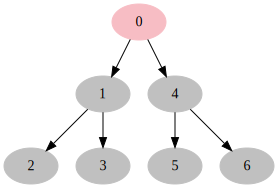

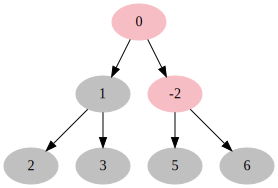

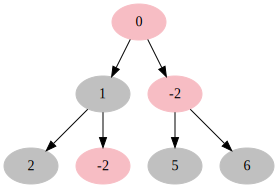

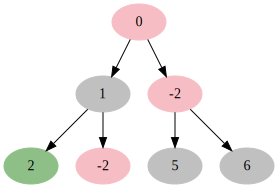

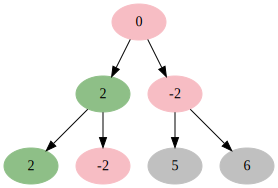

In [195]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

# Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [200]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis = 1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.333333     28
0.500000      2
0.500000      1
0.500000    452
0.500000      2
0.500000      3
1.000000    437
dtype: int64

Predictive power: 0.685


## Load Human Data

In [201]:
from analysis_utils import *
VERSION = 'c0.5'
data = get_data(VERSION, '../experiment/data')
pdf = data['participants']
print(f'{len(pdf)} participants')
mdf = data['mouselab-mdp']
tdf = mdf.query('block == "test"').copy()

tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

tdf['clicks'] = tdf.queries.apply(extract)
tdf['n_clicks'] = tdf.clicks.apply(len)
pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.sum()

9 participants


In [202]:
TRIALS = pd.read_json('../experiment/experiment/static/json/binary_tree_constant_high.json')
TRIALS = TRIALS.drop_duplicates(subset='trial_id').set_index('trial_id').stateRewards

assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = make_env(mu=3, sigma=6, ground_truth=TRIALS.loc[row.trial_id])
#         assert (hash(env) % 100000000) == row.trial_id
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)

data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

## Grid Search on temperature and error probability

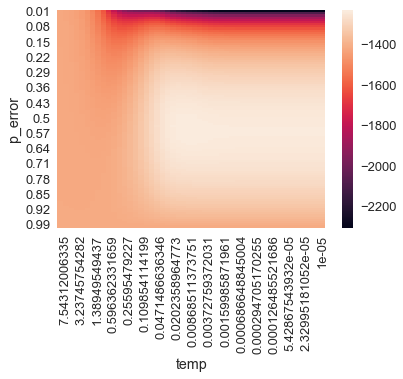

In [266]:
from mouselab_policy import MouselabPolicy
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)

p_rand = np.stack(data.state.apply(rand_policy.action_distribution))[chosen]

def logp_grid(data):
    prefs = np.stack(data.state.apply(optimal_policy.preferences))
    prefs -= prefs.max(1).reshape(-1, 1)  # prevent float overflow 
    idx = np.arange(len(data))
    chosen = (idx, data.action.as_matrix())
    p_rand = np.stack(data.state.apply(rand_policy.action_distribution))[chosen]

    def logp(temp, p_error):
        eq = np.exp(prefs / temp)
        p_model = eq[chosen] / eq.sum(1)
        return np.log(p_error * p_rand + (1-p_error) * p_model)
               
    def items():
        for t in np.logspace(-5,1, base=10):
            for pe in np.linspace(0.01,1, 100):
                yield {'temp': t, 'p_error': pe, 'logp': logp(t, pe).sum()}

    return (DataFrame(items()) 
            .set_index(['p_error', 'temp']) 
            .logp.unstack())

# Up and right are becoming less random.
sns.heatmap(logp_grid(data)).invert_xaxis()

In [277]:
from scipy.optimize import minimize

def mle(data):
    logp = logp_grid(data).stack()
    p_error, temp = logp.idxmax()
    best = logp[p_error, temp]
    baseline = logp.iloc[-1]  # p_error = 1
    return {'temp': temp, 
            'p_error': p_error,
            'log_likelihood': best,
            'baseline': baseline,
            'LLR':best - baseline,
            'score': (best - baseline) / len(data)
           }

MLE = DataFrame(list(data.groupby('pid').apply(mle)))
pdf['model_score'] = MLE.score
print('Predictive power over the random model.')
print(MLE.score)

Predictive power over the random model.
0    0.274082
1    0.294032
2    0.000000
3    0.037724
4    0.538087
5    0.118559
6    0.591950
7    0.101470
8    0.121687
Name: score, dtype: float64


In [283]:
MLE['temp p_error LLR'.split()]

,temp,p_error,LLR
0,0.020236,0.47,29.326739
1,0.000010,0.50,28.521115
2,0.000010,1.00,0.000000
3,0.035565,0.81,2.678401
4,0.006551,0.28,70.489380
5,0.000010,0.71,10.670333
6,0.035565,0.19,77.545474
7,0.000010,0.70,6.088225
8,0.020236,0.65,14.237408


## Individual differences

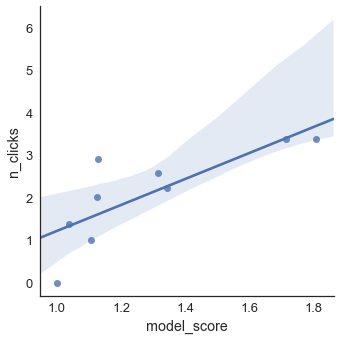

In [240]:
sns.lmplot('model_score', 'n_clicks', data=pdf)

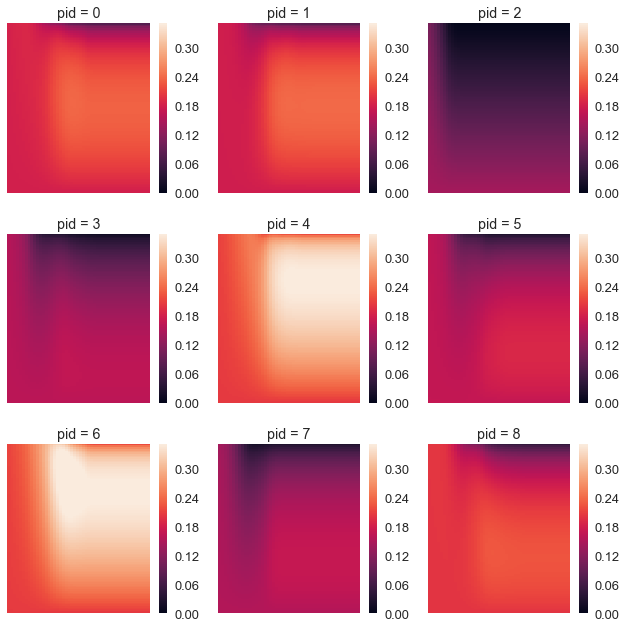

In [267]:
def plotter(data, **kwargs):
    pid = data.pid.iloc[0]
    sns.heatmap(np.exp(logp_grid(data) / len(data)), vmin=0, vmax=0.35).invert_xaxis()
    plt.xticks([])
    plt.yticks([])
    plt.title(f'score = {MLE.score[pid]}')
    

g = sns.FacetGrid(data, col='pid', col_wrap=3)
g.map_dataframe(plotter)